In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [44]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage


import pandas as pd
import numpy as np
import scipy
import pprint

In [3]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

In [30]:
storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)

## List of available products in Mongo

In [50]:
swm_info = storage.swarms_info()
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(swm_info)

{   '_id': None,
    'alphas': [   'RenkoPatterns_no_exit_on_patterns',
                  'PointAndFigurePatterns',
                  'SwingPoint',
                  'MACross',
                  'IchimokuCloud',
                  'VolatilityCompression',
                  'BollingerBands'],
    'exo_types': ['CallSpread', 'BearishCollarBW', 'BullishCollarBW'],
    'instruments': ['ES']}


## Getting swarm using filter

In [52]:
instruments_filter = ['*']  # Select ALL
#instruments_filter = ['ES', 'CL']

exo_filter = ['*'] # Select ALL
exo_filter = ['BullishCollar']

direction_filter = [0, -1, 1] # Select ALL
direction_filter = [1]

alpha_filter = ['*']  # Select ALL
#alpha_filter = ['MaCross', 'PointAndFigurePatterns']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

## Swarms loaded

In [59]:
[print(s) for s in sorted(swmdf.columns)];

ES_BullishCollarBW_Long_BollingerBands
ES_BullishCollarBW_Long_IchimokuCloud
ES_BullishCollarBW_Long_MACross
ES_BullishCollarBW_Long_PointAndFigurePatterns
ES_BullishCollarBW_Long_RenkoPatterns_no_exit_on_patterns_no-exit-on-patterns
ES_BullishCollarBW_Long_SwingPoint
ES_BullishCollarBW_Long_VolatilityCompression


### Swarms equities

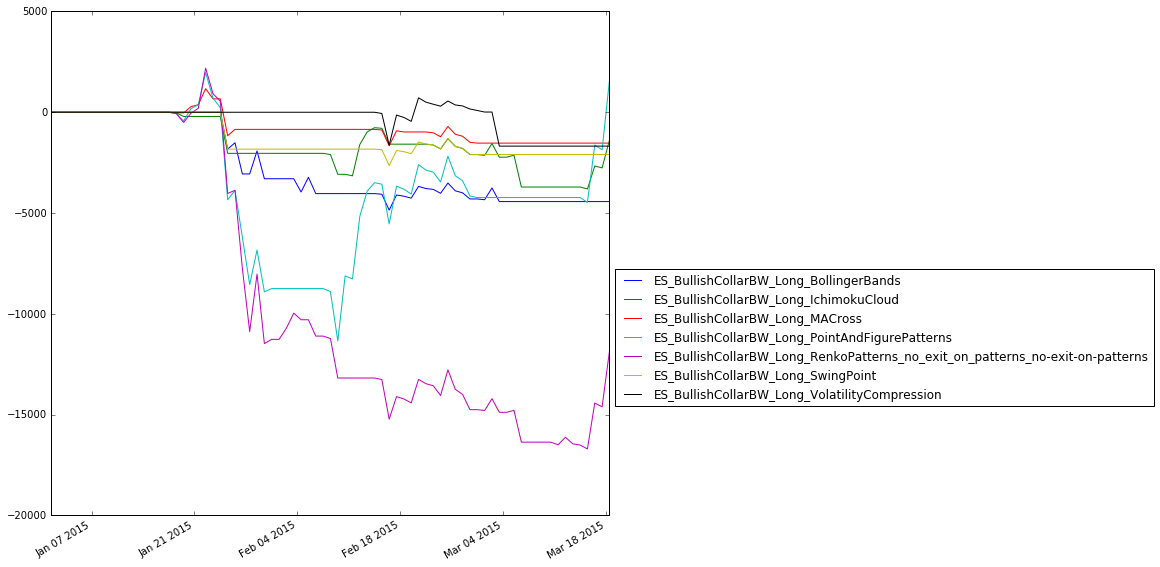

In [90]:
swmdf.plot().legend(loc='best', bbox_to_anchor=(1, 0.5));

## Individual swarm equity

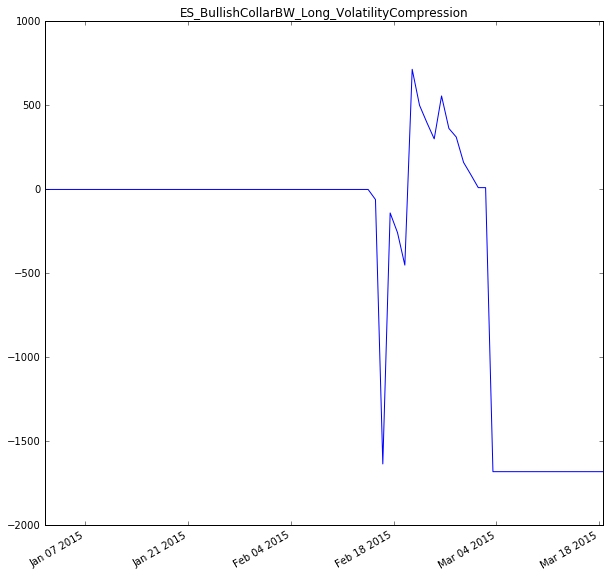

In [95]:
#_swarm_name = "ES_BullishCollarBW_Long_BollingerBands"
_swarm_name = "ES_BullishCollarBW_Long_VolatilityCompression"

swmdf[_swarm_name].plot();
title(_swarm_name);

### Available products EXOs

In [105]:
passive_exo = {}

exo_filter = '*'     # All 
#exo_filter = 'ES_'  # ES only
exo_filter = 'ES*Collar'  # ES Collars (incl Bearish, Bullish, BW and vanilla)


print('==== Passive EXO list')
for exo_name in storage.exo_list(exo_filter):
    passive_exo[exo_name], exo_dict = storage.load_series(exo_name)

for exo in sorted(passive_exo.keys()):
    print(exo)
    
print('==== Alphas EXO list')
[print(s) for s in sorted(swmdf.columns)];

==== Passive EXO list
ES_BearishCollarBW
ES_BullishCollar
ES_BullishCollarBW
==== Alphas EXO list
ES_BullishCollarBW_Long_BollingerBands
ES_BullishCollarBW_Long_IchimokuCloud
ES_BullishCollarBW_Long_MACross
ES_BullishCollarBW_Long_PointAndFigurePatterns
ES_BullishCollarBW_Long_RenkoPatterns_no_exit_on_patterns_no-exit-on-patterns
ES_BullishCollarBW_Long_SwingPoint
ES_BullishCollarBW_Long_VolatilityCompression


In [106]:
storage.load_series('ZN_PutSpread')

(                   exo
 2015-08-01    0.000000
 2015-08-02  -11.619083
 2015-08-03 -161.222117
 2015-08-04  168.197992
 2015-08-05  590.642447,
 {'margin': 0,
  'name': 'ZN_PutSpread',
  'pcf': [],
  'pcfqty': [],
  'underlying': ''})

# Campaign composition

Copy/paste EXO or swarm names to the 'campaign_exposure' dictionary from lists above

In [74]:
campaign_exposure = {
     'ES_BullishCollarBW_Long_BollingerBands': 1,
     'ES_BullishCollarBW_Long_VolatilityCompression': 1,
     'ES_BullishCollarBW_Long_IchimokuCloud': 1,
     
     #
     # Passive EXO positions
     #
     'ES_BearishCollarBW': -1, # Short 1 EXO units
     
}

In [77]:
#def campaign_equity(swarms, exposure):

campaign_dict = {}
campaign_stats = {'NetProfit': 0.0, 'TradesCount': 0, 'CommissionSum': 0.0}

for camp_name, exposure in campaign_exposure.items():
    if camp_name in swmdf:
        swarm_name = camp_name
        campaign_dict[swarm_name] = swmdf[swarm_name] * exposure
        
        # TODO: implement swarm statistics
        '''
        s = smgr.picked_stats        
        campaign_stats['NetProfit'] += s['NetProfit']
        campaign_stats['TradesCount'] += s['TradesCount']
        campaign_stats['CommissionSum'] += s['CommissionSum']
        '''
        
    elif camp_name in passive_exo:
        exo_equity = passive_exo[camp_name]
        campaign_dict[camp_name] = exo_equity.diff() * exposure
    
    
campaign_portfolio = pd.DataFrame(campaign_dict)
campaign_equity = campaign_portfolio.sum(axis=1)

### Campaign members equities

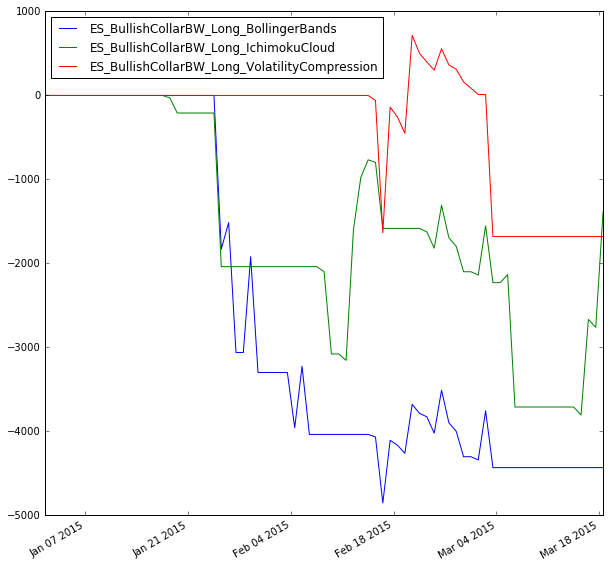

In [78]:
figsize(10,10)
campaign_portfolio.plot()

### Cumulative campaign equity

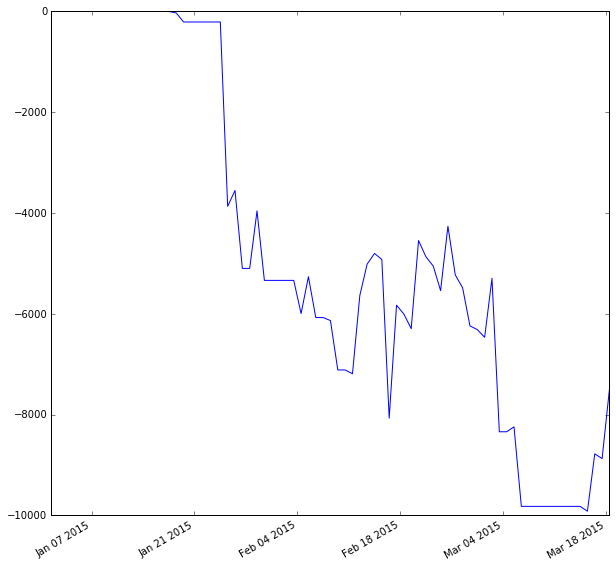

In [79]:
campaign_portfolio.sum(axis=1).plot()

# Campaign statistics

In [80]:
print(campaign_stats)

{'CommissionSum': 0.0, 'TradesCount': 0, 'NetProfit': 0.0}
